In [1]:
import os
import copy 
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import metrics
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.table import Table
from IPython.display import display, HTML
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from tensorflow.keras.optimizers import Adam

In [2]:
np.random.seed(42)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    
    tf.config.experimental.set_memory_growth(gpus[0], True)

Num GPUs Available:  1


In [3]:
folder_path = '/kaggle/input/data02/Offshore Wind Farm Dataset1(WT5).csv'
df = pd.read_csv(folder_path)

### Utility Functions

In [4]:
def get_sample_df(df):
    return df[:1440] # 1441

def get_sampe_train_test_data(df):
    get_sample_df(df)
    train_df, test_df = split_dataframe(sample_df)
    return train_df, test_df

def split_dataframe(df, split_ratio=0.8):
    split_index = int(len(df) * split_ratio)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]
    return train_df, test_df

def concatenate_train_test(train_df, test_df):
    train_df = pd.DataFrame(train_df)
    test_df = pd.DataFrame(test_df)
    
    concatenated_df = pd.concat([train_df, test_df], ignore_index=True)
    return concatenated_df

In [5]:
def create_table(data, filename='model_results.png', figsize=(12, 4)):
    df = pd.DataFrame(data)
    
    fig, ax = plt.subplots(figsize=figsize)  # You can adjust the figure size
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    display(HTML(df.to_html(index=False)))

In [6]:
def plot_wind_power(train_df, test_df, title, outliers=None, test_outliers=None):
    plt.figure(figsize=(12, 6))
    plt.plot(train_df.index, train_df['y (% relative to rated power)'], label='Train Data', color='blue')
    plt.plot(test_df.index, test_df['y (% relative to rated power)'], label='Test Data', color='brown', linestyle='--')
    plt.xlabel('Data Point Index')
    plt.ylabel('Offshore Wind Power (%)')
    plt.title('Offshore Wind Power - Train and Test Data')
    
    if outliers is not None:
        plt.scatter(train_df.index[outliers], train_df['y (% relative to rated power)'][outliers], color='orange', label='Outliers', zorder=2.5)
    if test_outliers is not None:
        plt.scatter(test_df.index[test_outliers], test_df['y (% relative to rated power)'][test_outliers], color='orange', label='Outliers', zorder=2.5)
    
    plt.xlabel('Data Point Index')
    plt.ylabel('Offshore Wind Power (%)')
    plt.title(title)
    plt.legend()
    plt.show()

In [7]:
def plot_merged_wind_power(train_df, test_df, denoised_train_y, denoised_test_y):
    plt.figure(figsize=(18, 9))

    plt.plot(train_df.index, train_df['y (% relative to rated power)'], label='Original Train Data', color='blue', linewidth=2)
    plt.plot(train_df.index, denoised_train_y, label='Denoised Train Data', color='orange', linestyle='--', linewidth=2)

    plt.plot(test_df.index, test_df['y (% relative to rated power)'], label='Original Test Data', color='blue', linewidth=2)
    plt.plot(test_df.index, denoised_test_y, label='Denoised Test Data', color='orange', linestyle='--', linewidth=2)

    plt.xlabel('Data Point Index')
    plt.ylabel('Offshore Wind Power (%)')
    plt.title('Original and Denoised Offshore Wind Power Data (y % relative to rated power)')
    plt.legend()
    plt.show()


In [8]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.show()

In [9]:
def calculate_rolling_statistics(dataframe, window_size):
    dataframe_column = dataframe['y (% relative to rated power)']
    rolling_mean = dataframe_column.rolling(window=window_size, center=True).mean()
    rolling_variance = dataframe_column.rolling(window=window_size, center=True).var()
    return rolling_mean, rolling_variance

def identify_outliers(dataframe, rolling_mean, rolling_variance, threshold=1):
    dataframe_column = dataframe['y (% relative to rated power)']
    std_dev = np.sqrt(rolling_variance)
    upper_limit = rolling_mean + (threshold * std_dev)
    lower_limit = rolling_mean - (threshold * std_dev)

    outliers = (dataframe_column > upper_limit) | (dataframe_column < lower_limit)
    return outliers

### AutoEncoder

In [10]:
class AutoEncoder:
    def __init__(self, input_dim, encoding_dim, hidden_dims=[], activation="relu", learning_rate=0.001):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.hidden_dims = hidden_dims
        self.activation = activation
        self.learning_rate = learning_rate

        self.autoencoder, self.encoder, self.decoder = self._build_model()

    def _build_model(self):
        # Encoder
        encoder_input = layers.Input(shape=(self.input_dim,))
        x = encoder_input
        for hidden_dim in self.hidden_dims:
            x = layers.Dense(hidden_dim, activation=self.activation)(x)
        encoded = layers.Dense(self.encoding_dim, activation=self.activation)(x)

        # Decoder
        decoder_input = layers.Input(shape=(self.encoding_dim,))
        x = decoder_input
        for hidden_dim in reversed(self.hidden_dims):
            x = layers.Dense(hidden_dim, activation=self.activation)(x)
        decoded = layers.Dense(self.input_dim, activation="sigmoid")(x)

        # Models
        encoder = models.Model(encoder_input, encoded, name="Encoder")
        decoder = models.Model(decoder_input, decoded, name="Decoder")
        autoencoder = models.Model(encoder_input, decoder(encoder(encoder_input)), name="AutoEncoder")

        autoencoder.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss="mse"
        )
        return autoencoder, encoder, decoder

    # def train(self, x_train, x_val, batch_size=32, epochs=50):
    def train(self, x_train, batch_size=32, epochs=50):
        return self.autoencoder.fit(
            x_train, x_train,
            # validation_data=(x_val, x_val),
            batch_size=batch_size,
            epochs=epochs,
            shuffle=True
        )

    def encode(self, data):
        return self.encoder.predict(data)

    def decode(self, data):
        return self.decoder.predict(data)

### Build models

In [58]:
def build_mlp(input_dim, outputdim):
    # print(input_dim.shape)
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(outputdim)
    ])
    return model

def build_rnn(input_dim, outputdim):
    print(input_dim)
    model = models.Sequential([
        layers.Input(shape=(input_dim)),
        layers.SimpleRNN(64, activation='relu', return_sequences=False),
        layers.Dense(outputdim)
    ])
    return model

def build_transformer(input_dim, outputdim, dropout_rate=0.1, num_heads=12, key_dim=256):
    # Flatten the last dimension if input_dim has an extra channel
    if len(input_dim) == 3:
        input_dim = input_dim[:-1]  # Reduce to (144, 7)
    
    sequence_length, feature_dim = input_dim
    input_layer = layers.Input(shape=(sequence_length, feature_dim))

    # Project features into an embedding space
    embedded_input = layers.Dense(key_dim)(input_layer)  # Shape: (batch_size, sequence_length, key_dim)

    # Apply multi-head attention
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
        embedded_input, embedded_input
    )  # Shape: (batch_size, sequence_length, key_dim)

    # Add dropout
    attention_output = layers.Dropout(dropout_rate)(attention_output)

    # Pool across the sequence
    x = layers.GlobalAveragePooling1D()(attention_output)  # Shape: (batch_size, key_dim)

    # Fully connected layers
    x = layers.Dense(64, activation="relu")(x)
    output_layer = layers.Dense(outputdim)(x)  # Shape: (batch_size, 1)

    return models.Model(inputs=input_layer, outputs=output_layer)

### Loss Functions

In [12]:
def huber_loss(delta=1.0):
    def loss_fn(y_true, y_pred):
        error = y_true - y_pred
        condition = tf.abs(error) <= delta
        squared_loss = 0.5 * tf.square(error)
        linear_loss = delta * (tf.abs(error) - 0.5 * delta)
        return tf.where(condition, squared_loss, linear_loss)
    return loss_fn

def rmse_metric(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

### Optimization Algorithms

In [13]:
class SlimeMouldOptimization: # baad az plot hashem of denoise. 
    def __init__(self, obj_function, num_agents, num_iterations, bounds, a=1, b=0.5):
        self.obj_function = obj_function
        self.num_agents = num_agents
        self.num_iterations = num_iterations
        self.bounds = bounds
        self.a = a
        self.b = b

        # Initialize the agents
        self.num_dimensions = len(bounds)
        self.agents = np.random.uniform(bounds[:, 0], bounds[:, 1], (num_agents, self.num_dimensions))
        self.best_agent = None
        self.best_fitness = float("inf")

    def optimize(self):
        for t in range(self.num_iterations):
            # Evaluate fitness
            fitness = np.array([self.obj_function(agent) for agent in self.agents])

            # Update the best solution
            if np.min(fitness) < self.best_fitness:
                self.best_fitness = np.min(fitness)
                self.best_agent = self.agents[np.argmin(fitness)]

            # Calculate weights (W)
            sorted_indices = np.argsort(fitness)
            weights = np.zeros(self.num_agents)
            for i, idx in enumerate(sorted_indices):
                if i < self.num_agents // 2:
                    weights[idx] = 1 + np.random.random() * np.log10(1 + fitness[idx] / (fitness[0] + 1e-8))
                else:
                    weights[idx] = 1 - np.random.random() * np.log10(1 + fitness[idx] / (fitness[-1] + 1e-8))

            # Update positions
            for i in range(self.num_agents):
                r = np.random.random()
                if r < self.b:
                    # Exploitation phase
                    best_index = sorted_indices[0]
                    self.agents[i] += weights[i] * (self.agents[best_index] - self.agents[i])
                else:
                    # Exploration phase
                    random_agent = self.agents[np.random.randint(self.num_agents)]
                    self.agents[i] += self.a * (random_agent - self.agents[i])

                # Ensure agents stay within bounds
                self.agents[i] = np.clip(self.agents[i], self.bounds[:, 0], self.bounds[:, 1])

        return {"best_agent": self.best_agent, "best_fitness": self.best_fitness}

### Implementations

In [14]:
selected_df = df
sample_df = get_sample_df(df)

In [15]:
sample_df

,Sequence No.,V,D,air density,humidity,I,S_a,S_b,y (% relative to rated power)
0,1,6.873766,174.05750,1.219331,50.082808,0.021919,0.110258,0.135261,11.653333
1,2,7.096613,176.44390,1.219144,48.541693,0.037737,0.061554,0.156136,30.550000
2,3,8.101572,176.31330,1.218397,46.252931,0.049063,0.152517,0.223355,43.850000
3,4,8.762237,181.03170,1.219514,47.099364,0.094166,0.254332,0.256441,51.660000
4,5,9.901171,183.54340,1.216877,44.129409,0.027735,0.073538,0.311642,46.406667
...,...,...,...,...,...,...,...,...,...
1435,1436,9.977341,85.88867,1.219528,47.055129,0.063370,0.028694,0.154906,44.973333
1436,1437,9.665076,87.14518,1.220529,48.844004,0.074035,0.021693,0.120340,55.166667
1437,1438,8.731282,87.78748,1.220735,49.861033,0.070810,0.151179,0.037868,43.576667
1438,1439,8.714778,87.20252,1.220978,50.698143,0.075362,0.179249,0.042282,38.946667


In [16]:
sample_train_df, sample_test_df = get_sampe_train_test_data(df)

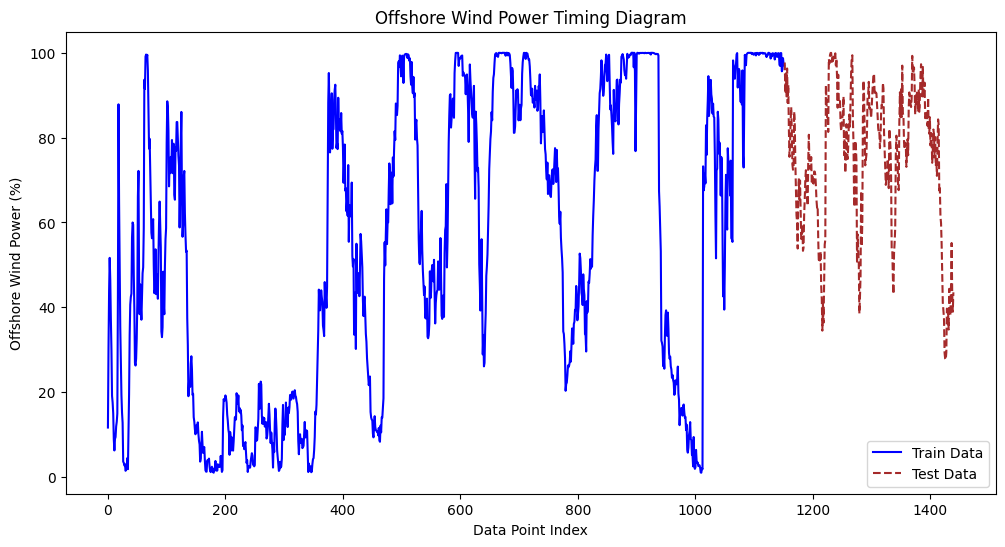

In [17]:
plot_wind_power(sample_train_df, sample_test_df, title='Offshore Wind Power Timing Diagram')

In [18]:
train_rolling_mean, train_rolling_variance = calculate_rolling_statistics(sample_train_df, window_size=48)
test_rolling_mean, test_rolling_variance = calculate_rolling_statistics(sample_test_df, window_size=48)

outliers = identify_outliers(sample_train_df, train_rolling_mean, train_rolling_variance)
test_outliers = identify_outliers(sample_test_df, test_rolling_mean, test_rolling_variance)

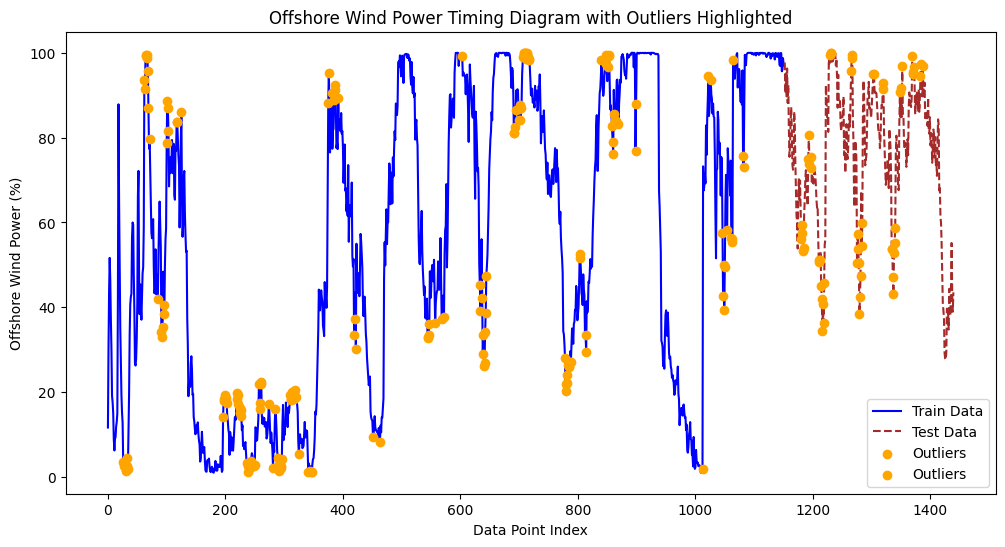

In [19]:
plot_wind_power(sample_train_df, sample_test_df, 'Offshore Wind Power Timing Diagram with Outliers Highlighted', outliers, test_outliers)

### Correlation

In [20]:
# plot_correlation_matrix(selected_df)
# selected_df.head()
# selected_df = selected_df.drop('V', axis=1)

In [21]:
selected_df = selected_df.drop('Sequence No.', axis=1)

In [22]:
# selected_df.head()
# plot_correlation_matrix(selected_df)

### Split to Train and Test

In [23]:
train_data, test_data = split_dataframe(pd.DataFrame(selected_df))

### Denoising 

In [24]:
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
normalized_train_data = scaler.fit_transform(train_data)

# Transform the test data using the same scaler (learned from the training data)
normalized_test_data = scaler.transform(test_data)

In [25]:
normalized_df = concatenate_train_test(normalized_train_data, normalized_test_data)

In [26]:
# Train AutoEncoder
autoencoder = AutoEncoder(input_dim=normalized_df.shape[1], encoding_dim=2, hidden_dims=[16, 8])
autoencoder.train(x_train=normalized_df, epochs=50, batch_size=64)

# Denoise Data
denoised_data = autoencoder.autoencoder.predict(normalized_df)

Epoch 1/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0681
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0174
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0142
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0123
Epoch 5/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0108
Epoch 6/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0099
Epoch 7/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095
Epoch 8/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092
Epoch 9/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090
Epoch 10/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090
Epoch 11/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089
Epoch 12/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088
Epoch 13/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088
Epoch 14/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087
Epoch 15/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - lo

In [27]:
denoised_data_copy = copy.deepcopy(denoised_data)
denoised_data_copy = scaler.inverse_transform(denoised_data_copy)
denoised_df_copy = get_sample_df(pd.DataFrame(denoised_data_copy, columns=['V', 'D', 'air density', 'humidity', 'I', 'S_a', 'S_b', 'y (% relative to rated power)']))

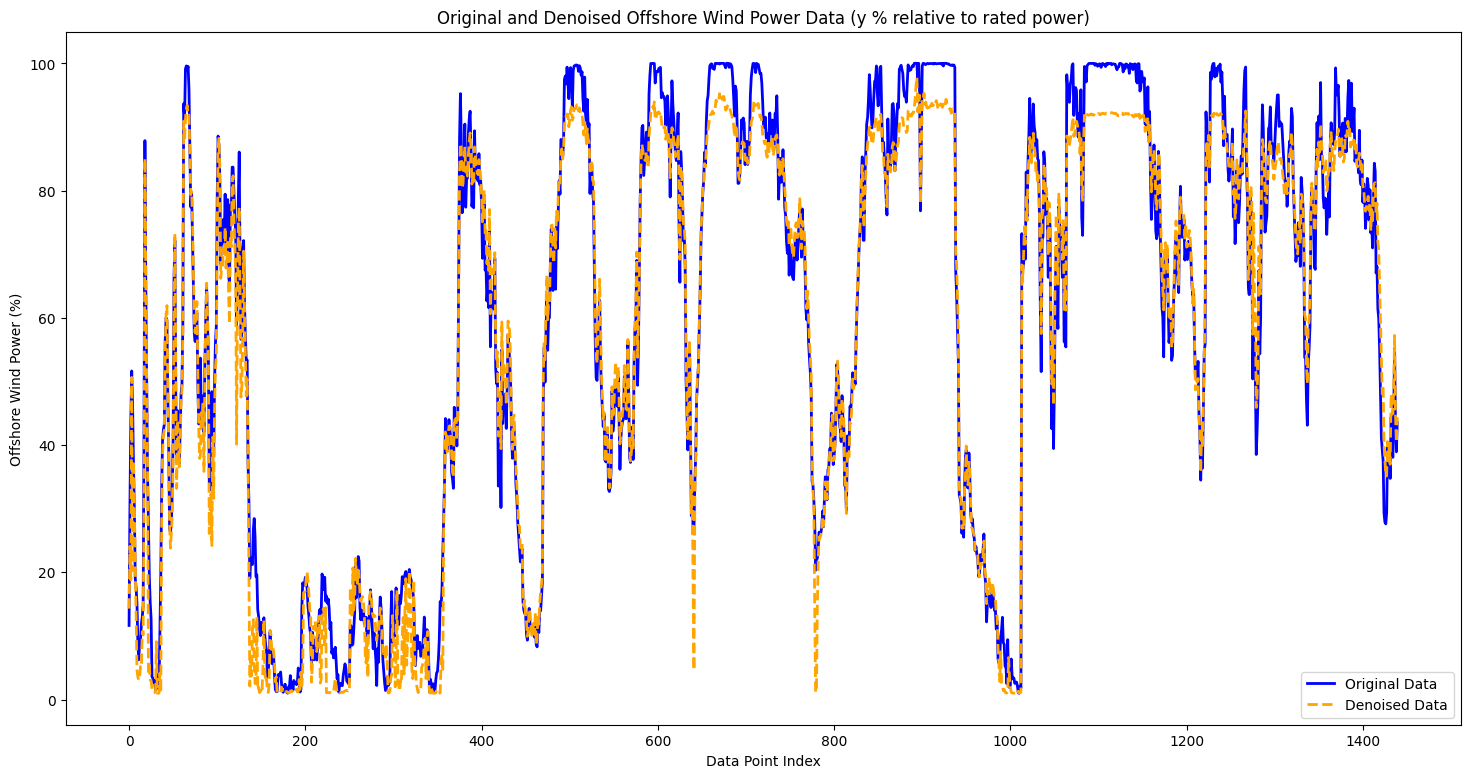

In [28]:
plt.figure(figsize=(18, 9))

plt.plot(sample_df.index, sample_df['y (% relative to rated power)'], label='Original Data', color='blue', linewidth=2)
plt.plot(sample_df.index, denoised_df_copy['y (% relative to rated power)'], label='Denoised Data', color='orange', linestyle='--', linewidth=2)


plt.xlabel('Data Point Index')
plt.ylabel('Offshore Wind Power (%)')
plt.title('Original and Denoised Offshore Wind Power Data (y % relative to rated power)')
plt.legend()
plt.show()

In [29]:
denoised_train_data, denoised_test_data = split_dataframe(pd.DataFrame(denoised_data))

print(denoised_train_data.shape)
print(denoised_test_data.shape)

(13154, 8)
(3289, 8)


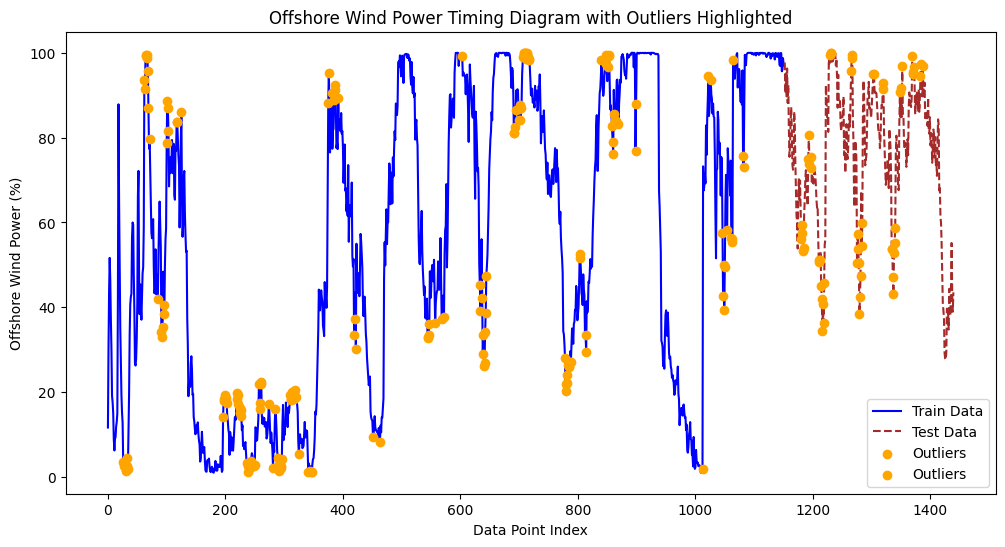

In [76]:
denoised_sample_df = get_sample_df(denoised_df_copy)
denoised_sample_train_df, denoised_sample_test_df = get_sampe_train_test_data(denoised_sample_df)
denoised_train_rolling_mean, denoised_train_rolling_variance = calculate_rolling_statistics(denoised_sample_train_df, window_size=48)
denoised_test_rolling_mean, denoised_test_rolling_variance = calculate_rolling_statistics(denoised_sample_test_df, window_size=48)

denoised_outliers = identify_outliers(denoised_sample_train_df, denoised_train_rolling_mean, denoised_train_rolling_variance)
denoised_test_outliers = identify_outliers(denoised_sample_test_df, denoised_test_rolling_mean, denoised_test_rolling_variance)
plot_wind_power(denoised_sample_train_df, denoised_sample_test_df, 'Offshore Wind Power Timing Diagram with Outliers Highlighted', denoised_outliers, denoised_test_outliers)

### Training

In [31]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [32]:
denoised_df_copy

,V,D,air density,humidity,I,S_a,S_b,y (% relative to rated power)
0,6.749743,215.980331,1.221223,80.826019,0.060744,0.140941,0.071434,14.300215
1,7.627381,223.743942,1.221402,80.190544,0.060211,0.117508,0.070382,24.097290
2,7.139046,102.793648,1.252472,85.992744,0.078743,0.115969,0.047234,18.822277
3,9.419668,97.202209,1.199927,49.601952,0.067939,0.238005,0.180531,50.644421
4,7.260724,89.128616,1.255851,86.644531,0.081659,0.111706,0.044412,20.285923
...,...,...,...,...,...,...,...,...
1435,9.074034,70.361084,1.209424,58.499966,0.067837,0.134831,0.089699,49.434780
1436,9.634650,67.342331,1.211668,59.310051,0.067918,0.124620,0.085678,57.226418
1437,8.754466,72.211792,1.209662,58.965023,0.068384,0.139599,0.090723,44.724541
1438,8.470493,73.879356,1.210126,59.533409,0.068961,0.143834,0.091317,40.473610


In [33]:
print (denoised_data[:, -1])

[0.13429587 0.23321958 0.17995635 ... 0.87795675 0.8991691  0.88905585]


In [66]:
def create_sliding_window(data, prediction_size=1, window_size=144):
    X, y = [], []
    for i in range(len(data) - window_size - prediction_size + 1):
        X.append(data[i : i+window_size])
        y.append(data[i+window_size : i+window_size+prediction_size])
    return np.array(X), np.array(y)

one_step_X, one_step_y = create_sliding_window(denoised_data, prediction_size=1, window_size=144)

X_train, X_test, y_train, y_test = train_test_split(one_step_X, one_step_y, test_size=0.2, random_state=42)

corected_X_trian = X_train[:, :, :-1]
corected_X_test = X_test[:, :, :-1]
corected_y_train = y_train[:, :, -1]
corected_y_test = y_test[:, :, -1]

print('X_train:', X_train.shape, ', y_train: ', y_train.shape)
print('X_test:', X_test.shape, ', y_test: ', y_test.shape)

X_train_flat = corected_X_trian.reshape(corected_X_trian.shape[0], -1)
X_test_flat = corected_X_test.reshape(corected_X_test.shape[0], -1)

print('X_train_flat:', X_train_flat.shape)
print('X_test_flat:', X_test_flat.shape)

X_train_seq = np.expand_dims(corected_X_trian, axis=-1)
X_test_seq = np.expand_dims(corected_X_test, axis=-1)

print('X_train_seq:', X_train_seq.shape)
print('X_test_seq:', X_test_seq.shape)

X_train: (13039, 144, 8) , y_train:  (13039, 1, 8)
X_test: (3260, 144, 8) , y_test:  (3260, 1, 8)
X_train_flat: (13039, 1008)
X_test_flat: (3260, 1008)
X_train_seq: (13039, 144, 7, 1)
X_test_seq: (3260, 144, 7, 1)


In [35]:
print (y_train.shape)

(13039, 1, 8)


In [36]:
losses = {
    "MSE": "mse",
    "Huber": huber_loss(delta=1.0),
}
# models_dict = {
#     "MLP": build_mlp(input_dim=X_train_flat.shape[1]),
#     "RNN": build_rnn(input_dim=corected_X_trian.shape[1:])
#     # "Transformer": build_transformer(input_dim=X_train_seq.shape[1:])
# }

In [47]:
data = []

for model_name in {"Transformer", "MLP", "RNN"}:
    for loss_name, loss_fn in losses.items():
        print(f"Evaluating {model_name} with {loss_name} loss...")
        model = None
        # Compile the model with proper metrics
        if model_name == "MLP":
            model = build_mlp(input_dim=X_train_flat.shape[1], outputdim=1)
            model.compile(optimizer='adam', loss=loss_fn, metrics=[metrics.MeanAbsoluteError(), rmse_metric, metrics.MeanAbsolutePercentageError()])
            history = model.fit(X_train_flat, corected_y_train, batch_size=32, epochs=20, shuffle=True)
        elif model_name == "RNN":
            model = build_rnn(input_dim=corected_X_trian.shape[1:], outputdim=1)
            model.compile(optimizer='adam', loss=loss_fn, metrics=[metrics.MeanAbsoluteError(), rmse_metric, metrics.MeanAbsolutePercentageError()])
            history = model.fit(X_train_seq, corected_y_train, batch_size=32, epochs=20, shuffle=True)
        else :
            model = build_transformer(input_dim=corected_X_trian.shape[1:], outputdim=1)
            model.compile(optimizer='adam', loss=loss_fn, metrics=[metrics.MeanAbsoluteError(), rmse_metric, metrics.MeanAbsolutePercentageError()])
            history = model.fit(X_train_seq, corected_y_train, batch_size=128, epochs=50, shuffle=True)

        print(f"Evaluating {model_name} with {loss_name} loss...")
        if model_name == "MLP":
            y_pred = model.predict(X_test_flat)
        else:
            y_pred = model.predict(X_test_seq)
        
        print('y_test', y_test.shape)
        print('y_pred', y_pred.shape)
        
        y_pred = y_pred.squeeze(axis=-1)  # this converts (batch_size, time_steps, 1) to (batch_size, time_steps)

        print('y_test', y_pred.squeeze().shape)
        print('y_pred', corected_y_test.shape)

        mae = mean_absolute_error(corected_y_test, y_pred)
        mape = mean_absolute_percentage_error(corected_y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(corected_y_test, y_pred))
        r2 = 1 - np.sum((corected_y_test.squeeze() - y_pred.squeeze())**2) / np.sum((corected_y_test.squeeze() - corected_y_test.mean())**2)
        
        data.append({
            'Model': model_name,
            'Loss Function': loss_name,
            'MAE': f"{mae:.6f}",
            'MAPE': f"{mape:.6f}",
            'RMSE': f"{rmse:.6f}",
            'R2': f"{r2:.6f}"
        })

Evaluating MLP with MSE loss...
Epoch 1/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0704 - mean_absolute_error: 0.1983 - mean_absolute_percentage_error: 5004.2529 - rmse_metric: 0.2388
Epoch 2/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0143 - mean_absolute_error: 0.0883 - mean_absolute_percentage_error: 1853.9995 - rmse_metric: 0.1175
Epoch 3/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0121 - mean_absolute_error: 0.0807 - mean_absolute_percentage_error: 1242.0167 - rmse_metric: 0.1071
Epoch 4/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096 - mean_absolute_error: 0.0700 - mean_absolute_percentage_error: 1788.4922 - rmse_metric: 0.0945
Epoch 5/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 2273.2722 - rmse_metric: 0.0871
Epoch 6/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0607 - mean_absolute_percentage_error: 1629.7493 - rmse_metri

Model,Loss Function,MAE,MAPE,RMSE,R2
MLP,MSE,0.057816,4.284032,0.083469,0.932396
MLP,Huber,0.052013,2.634830,0.076833,0.942717
RNN,MSE,0.038581,5.835179,0.059015,0.966205
RNN,Huber,0.038287,4.494176,0.060180,0.964857
Transformer,MSE,0.134872,19.793905,0.170783,0.716980
Transformer,Huber,0.131675,13.636563,0.164747,0.736631


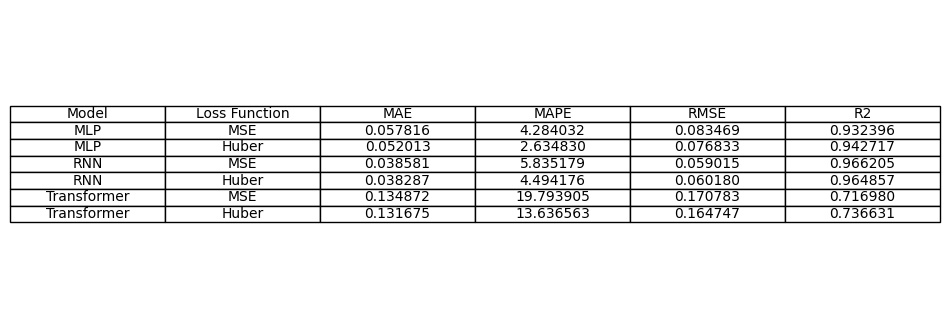

In [48]:
create_table(data)

In [39]:
# df = pd.DataFrame(data)

# fig, ax = plt.subplots(figsize=(12, 4))  # You can adjust the figure size
# ax.axis('tight')
# ax.axis('off')
# table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# plt.savefig('model_results.png', bbox_inches='tight', dpi=300)
# display(HTML(df.to_html(index=False)))


In [49]:
def create_sliding_window(data, prediction_size=1, window_size=144):
    X, y = [], []
    for i in range(len(data) - window_size - prediction_size + 1):
        X.append(data[i : i+window_size])
        y.append(data[i+window_size : i+window_size+prediction_size])
    return np.array(X), np.array(y)

one_step_X, one_step_y = create_sliding_window(denoised_data, prediction_size=4, window_size=144)

X_train, X_test, y_train, y_test = train_test_split(one_step_X, one_step_y, test_size=0.2, random_state=42)

corected_X_trian = X_train[:, :, :-1]
corected_X_test = X_test[:, :, :-1]
corected_y_train = y_train[:, :, -1]
corected_y_test = y_test[:, :, -1]

print('X_train:', corected_X_trian.shape, ', y_train: ', corected_y_train.shape)
print('X_test:', corected_X_test.shape, ', y_test: ', corected_y_test.shape)

X_train_flat = corected_X_trian.reshape(corected_X_trian.shape[0], -1)
X_test_flat = corected_X_test.reshape(corected_X_test.shape[0], -1)

print('X_train_flat:', X_train_flat.shape)
print('X_test_flat:', X_test_flat.shape)

X_train_seq = np.expand_dims(corected_X_trian, axis=-1)
X_test_seq = np.expand_dims(corected_X_test, axis=-1)

print('X_train_seq:', X_train_seq.shape)
print('X_test_seq:', X_test_seq.shape)

X_train: (13036, 144, 7) , y_train:  (13036, 4)
X_test: (3260, 144, 7) , y_test:  (3260, 4)
X_train_flat: (13036, 1008)
X_test_flat: (3260, 1008)
X_train_seq: (13036, 144, 7, 1)
X_test_seq: (3260, 144, 7, 1)


In [50]:
print(corected_y_train.shape)

(13036, 4)


In [52]:
data = []

for model_name in {"Transformer", "MLP", "RNN"}:
    for loss_name, loss_fn in losses.items():
        print(f"Evaluating {model_name} with {loss_name} loss...")
        model = None
        # Compile the model with proper metrics
        if model_name == "MLP":
            model = build_mlp(input_dim=X_train_flat.shape[1], outputdim=4)
            model.compile(optimizer='adam', loss=loss_fn, metrics=[metrics.MeanAbsoluteError(), rmse_metric, metrics.MeanAbsolutePercentageError()])
            history = model.fit(X_train_flat, corected_y_train, batch_size=32, epochs=20, shuffle=True)
        elif model_name == "RNN":
            model = build_rnn(input_dim=corected_X_trian.shape[1:], outputdim=4)
            model.compile(optimizer='adam', loss=loss_fn, metrics=[metrics.MeanAbsoluteError(), rmse_metric, metrics.MeanAbsolutePercentageError()])
            history = model.fit(X_train_seq, corected_y_train, batch_size=32, epochs=20, shuffle=True)
        else :
            model = build_transformer(input_dim=corected_X_trian.shape[1:], outputdim=4)
            model.compile(optimizer='adam', loss=loss_fn, metrics=[metrics.MeanAbsoluteError(), rmse_metric, metrics.MeanAbsolutePercentageError()])
            history = model.fit(X_train_seq, corected_y_train, batch_size=128, epochs=50, shuffle=True)

        print(f"Evaluating {model_name} with {loss_name} loss...")
        if model_name == "MLP":
            y_pred = model.predict(X_test_flat)
        else:
            y_pred = model.predict(X_test_seq)
        
        print('y_test', corected_y_test.shape)
        print('y_pred', y_pred.shape)
        

        mae = np.mean([mean_absolute_error(corected_y_test[:, i], y_pred[:, i]) for i in range(4)])
        mape = np.mean([mean_absolute_percentage_error(corected_y_test[:, i], y_pred[:, i])for i in range(4)])
        rmse = np.mean([np.sqrt(mean_squared_error(corected_y_test[:, i], y_pred[:, i])) for i in range(4)])
        # Calculate R² score for each sequence separately and average them
        r2_scores = []
        for i in range(4):
            r2 = 1 - np.sum((corected_y_test[:, i] - y_pred[:, i])**2) / np.sum((corected_y_test[:, i] - corected_y_test[:, i].mean())**2)
            r2_scores.append(r2)
        
        average_r2 = np.mean(r2_scores)

        
        data.append({
            'Model': model_name,
            'Loss Function': loss_name,
            'MAE': f"{mae:.6f}",
            'MAPE': f"{mape:.6f}",
            'RMSE': f"{rmse:.6f}",
            'R2': f"{r2:.6f}"
        })

Evaluating MLP with MSE loss...
Epoch 1/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0593 - mean_absolute_error: 0.1886 - mean_absolute_percentage_error: 4958.7266 - rmse_metric: 0.2282
Epoch 2/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0183 - mean_absolute_error: 0.1011 - mean_absolute_percentage_error: 2013.8722 - rmse_metric: 0.1334
Epoch 3/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0148 - mean_absolute_error: 0.0891 - mean_absolute_percentage_error: 2270.5852 - rmse_metric: 0.1196
Epoch 4/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0137 - mean_absolute_error: 0.0840 - mean_absolute_percentage_error: 2895.1890 - rmse_metric: 0.1151
Epoch 5/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0127 - mean_absolute_error: 0.0816 - mean_absolute_percentage_error: 1746.5129 - rmse_metric: 0.1107
Epoch 6/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0117 - mean_absolute_error: 0.0765 - mean_absolute_percentage_error: 2354.0942 - rmse_metri

Model,Loss Function,MAE,MAPE,RMSE,R2
MLP,MSE,0.062541,19.031906,0.092138,0.871083
MLP,Huber,0.101779,24.949947,0.130313,0.772908
RNN,MSE,0.058035,18.459522,0.088064,0.872939
RNN,Huber,0.061214,19.851849,0.090318,0.870929
Transformer,MSE,0.124282,32.878239,0.159917,0.742826
Transformer,Huber,0.130121,35.564049,0.168449,0.712509


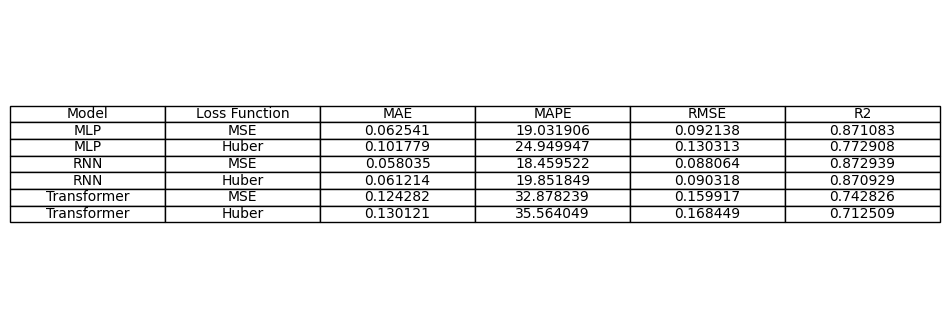

In [53]:
create_table(data)

In [55]:
def create_sliding_window(data, prediction_size=1, window_size=144):
    X, y = [], []
    for i in range(len(data) - window_size - prediction_size + 1):
        X.append(data[i : i+window_size])
        y.append(data[i+window_size : i+window_size+prediction_size])
    return np.array(X), np.array(y)

one_step_X, one_step_y = create_sliding_window(denoised_data, prediction_size=8, window_size=144)

X_train, X_test, y_train, y_test = train_test_split(one_step_X, one_step_y, test_size=0.2, random_state=42)

corected_X_trian = X_train[:, :, :-1]
corected_X_test = X_test[:, :, :-1]
corected_y_train = y_train[:, :, -1]
corected_y_test = y_test[:, :, -1]

print('X_train:', corected_X_trian.shape, ', y_train: ', corected_y_train.shape)
print('X_test:', corected_X_test.shape, ', y_test: ', corected_y_test.shape)

X_train_flat = corected_X_trian.reshape(corected_X_trian.shape[0], -1)
X_test_flat = corected_X_test.reshape(corected_X_test.shape[0], -1)

print('X_train_flat:', X_train_flat.shape)
print('X_test_flat:', X_test_flat.shape)

X_train_seq = np.expand_dims(corected_X_trian, axis=-1)
X_test_seq = np.expand_dims(corected_X_test, axis=-1)

print('X_train_seq:', X_train_seq.shape)
print('X_test_seq:', X_test_seq.shape)

X_train: (13033, 144, 7) , y_train:  (13033, 8)
X_test: (3259, 144, 7) , y_test:  (3259, 8)
X_train_flat: (13033, 1008)
X_test_flat: (3259, 1008)
X_train_seq: (13033, 144, 7, 1)
X_test_seq: (3259, 144, 7, 1)


In [56]:
data = []

for model_name in {"Transformer", "MLP", "RNN"}:
    for loss_name, loss_fn in losses.items():
        print(f"Evaluating {model_name} with {loss_name} loss...")
        model = None
        # Compile the model with proper metrics
        if model_name == "MLP":
            model = build_mlp(input_dim=X_train_flat.shape[1], outputdim=8)
            model.compile(optimizer='adam', loss=loss_fn, metrics=[metrics.MeanAbsoluteError(), rmse_metric, metrics.MeanAbsolutePercentageError()])
            history = model.fit(X_train_flat, corected_y_train, batch_size=32, epochs=30, shuffle=True)
        elif model_name == "RNN":
            model = build_rnn(input_dim=corected_X_trian.shape[1:], outputdim=8)
            model.compile(optimizer='adam', loss=loss_fn, metrics=[metrics.MeanAbsoluteError(), rmse_metric, metrics.MeanAbsolutePercentageError()])
            history = model.fit(X_train_seq, corected_y_train, batch_size=32, epochs=30, shuffle=True)
        else :
            model = build_transformer(input_dim=corected_X_trian.shape[1:], outputdim=8)
            model.compile(optimizer='adam', loss=loss_fn, metrics=[metrics.MeanAbsoluteError(), rmse_metric, metrics.MeanAbsolutePercentageError()])
            history = model.fit(X_train_seq, corected_y_train, batch_size=128, epochs=50, shuffle=True)

        print(f"Evaluating {model_name} with {loss_name} loss...")
        if model_name == "MLP":
            y_pred = model.predict(X_test_flat)
        else:
            y_pred = model.predict(X_test_seq)
        
        print('y_test', corected_y_test.shape)
        print('y_pred', y_pred.shape)
        

        mae = np.mean([mean_absolute_error(corected_y_test[:, i], y_pred[:, i]) for i in range(4)])
        mape = np.mean([mean_absolute_percentage_error(corected_y_test[:, i], y_pred[:, i])for i in range(4)])
        rmse = np.mean([np.sqrt(mean_squared_error(corected_y_test[:, i], y_pred[:, i])) for i in range(4)])
        # Calculate R² score for each sequence separately and average them
        r2_scores = []
        for i in range(4):
            r2 = 1 - np.sum((corected_y_test[:, i] - y_pred[:, i])**2) / np.sum((corected_y_test[:, i] - corected_y_test[:, i].mean())**2)
            r2_scores.append(r2)
        
        average_r2 = np.mean(r2_scores)

        
        data.append({
            'Model': model_name,
            'Loss Function': loss_name,
            'MAE': f"{mae:.6f}",
            'MAPE': f"{mape:.6f}",
            'RMSE': f"{rmse:.6f}",
            'R2': f"{r2:.6f}"
        })

Evaluating MLP with MSE loss...
Epoch 1/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0717 - mean_absolute_error: 0.2153 - mean_absolute_percentage_error: 5142.0039 - rmse_metric: 0.2557
Epoch 2/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0263 - mean_absolute_error: 0.1229 - mean_absolute_percentage_error: 4284.1914 - rmse_metric: 0.1601
Epoch 3/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0219 - mean_absolute_error: 0.1100 - mean_absolute_percentage_error: 2891.7578 - rmse_metric: 0.1461
Epoch 4/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0190 - mean_absolute_error: 0.1002 - mean_absolute_percentage_error: 2653.8401 - rmse_metric: 0.1358
Epoch 5/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0186 - mean_absolute_error: 0.0995 - mean_absolute_percentage_error: 2936.1294 - rmse_metric: 0.1345
Epoch 6/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0188 - mean_absolute_error: 0.0998 - mean_absolute_percentage_error: 2630.2446 - rmse_metri

Model,Loss Function,MAE,MAPE,RMSE,R2
MLP,MSE,0.063038,19.546246,0.092672,0.880559
MLP,Huber,0.074419,27.481785,0.102205,0.863739
RNN,MSE,0.059675,23.997797,0.090036,0.882171
RNN,Huber,0.070327,25.491070,0.100069,0.866813
Transformer,MSE,0.130215,33.939487,0.170030,0.711863
Transformer,Huber,0.141552,61.913929,0.183364,0.658616


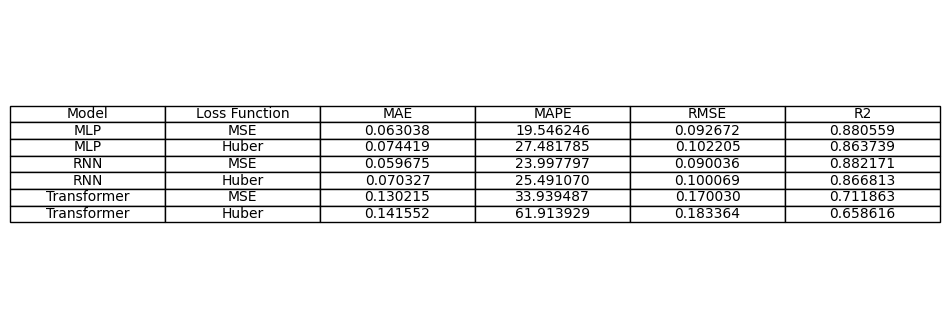

In [57]:
create_table(data)

In [59]:
def create_sliding_window(data, prediction_size=1, window_size=144):
    X, y = [], []
    for i in range(len(data) - window_size - prediction_size + 1):
        X.append(data[i : i+window_size])
        y.append(data[i+window_size : i+window_size+prediction_size])
    return np.array(X), np.array(y)

one_step_X, one_step_y = create_sliding_window(denoised_data, prediction_size=16, window_size=144)

X_train, X_test, y_train, y_test = train_test_split(one_step_X, one_step_y, test_size=0.2, random_state=42)

corected_X_trian = X_train[:, :, :-1]
corected_X_test = X_test[:, :, :-1]
corected_y_train = y_train[:, :, -1]
corected_y_test = y_test[:, :, -1]

print('X_train:', corected_X_trian.shape, ', y_train: ', corected_y_train.shape)
print('X_test:', corected_X_test.shape, ', y_test: ', corected_y_test.shape)

X_train_flat = corected_X_trian.reshape(corected_X_trian.shape[0], -1)
X_test_flat = corected_X_test.reshape(corected_X_test.shape[0], -1)

print('X_train_flat:', X_train_flat.shape)
print('X_test_flat:', X_test_flat.shape)

X_train_seq = np.expand_dims(corected_X_trian, axis=-1)
X_test_seq = np.expand_dims(corected_X_test, axis=-1)

print('X_train_seq:', X_train_seq.shape)
print('X_test_seq:', X_test_seq.shape)

X_train: (13027, 144, 7) , y_train:  (13027, 16)
X_test: (3257, 144, 7) , y_test:  (3257, 16)
X_train_flat: (13027, 1008)
X_test_flat: (3257, 1008)
X_train_seq: (13027, 144, 7, 1)
X_test_seq: (3257, 144, 7, 1)


In [61]:
data = []

for model_name in {"Transformer", "MLP", "RNN"}:
    for loss_name, loss_fn in losses.items():
        print(f"Evaluating {model_name} with {loss_name} loss...")
        model = None
        # Compile the model with proper metrics
        if model_name == "MLP":
            model = build_mlp(input_dim=X_train_flat.shape[1], outputdim=16)
            model.compile(optimizer='adam', loss=loss_fn, metrics=[metrics.MeanAbsoluteError(), rmse_metric, metrics.MeanAbsolutePercentageError()])
            history = model.fit(X_train_flat, corected_y_train, batch_size=32, epochs=30, shuffle=True)
        elif model_name == "RNN":
            model = build_rnn(input_dim=corected_X_trian.shape[1:], outputdim=16)
            model.compile(optimizer='adam', loss=loss_fn, metrics=[metrics.MeanAbsoluteError(), rmse_metric, metrics.MeanAbsolutePercentageError()])
            history = model.fit(X_train_seq, corected_y_train, batch_size=32, epochs=30, shuffle=True)
        else :
            model = build_transformer(input_dim=corected_X_trian.shape[1:], outputdim=16)
            model.compile(optimizer='adam', loss=loss_fn, metrics=[metrics.MeanAbsoluteError(), rmse_metric, metrics.MeanAbsolutePercentageError()])
            history = model.fit(X_train_seq, corected_y_train, batch_size=128, epochs=50, shuffle=True)

        print(f"Evaluating {model_name} with {loss_name} loss...")
        if model_name == "MLP":
            y_pred = model.predict(X_test_flat)
        else:
            y_pred = model.predict(X_test_seq)
        
        print('y_test', corected_y_test.shape)
        print('y_pred', y_pred.shape)
        

        mae = np.mean([mean_absolute_error(corected_y_test[:, i], y_pred[:, i]) for i in range(4)])
        mape = np.mean([mean_absolute_percentage_error(corected_y_test[:, i], y_pred[:, i])for i in range(4)])
        rmse = np.mean([np.sqrt(mean_squared_error(corected_y_test[:, i], y_pred[:, i])) for i in range(4)])
        # Calculate R² score for each sequence separately and average them
        r2_scores = []
        for i in range(4):
            r2 = 1 - np.sum((corected_y_test[:, i] - y_pred[:, i])**2) / np.sum((corected_y_test[:, i] - corected_y_test[:, i].mean())**2)
            r2_scores.append(r2)
        
        average_r2 = np.mean(r2_scores)

        
        data.append({
            'Model': model_name,
            'Loss Function': loss_name,
            'MAE': f"{mae:.6f}",
            'MAPE': f"{mape:.6f}",
            'RMSE': f"{rmse:.6f}",
            'R2': f"{r2:.6f}"
        })

Evaluating MLP with MSE loss...
Epoch 1/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0727 - mean_absolute_error: 0.2163 - mean_absolute_percentage_error: 5817.9873 - rmse_metric: 0.2603
Epoch 2/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0353 - mean_absolute_error: 0.1439 - mean_absolute_percentage_error: 5092.7017 - rmse_metric: 0.1867
Epoch 3/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0332 - mean_absolute_error: 0.1379 - mean_absolute_percentage_error: 4368.8501 - rmse_metric: 0.1805
Epoch 4/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0324 - mean_absolute_error: 0.1360 - mean_absolute_percentage_error: 3884.6106 - rmse_metric: 0.1782
Epoch 5/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0306 - mean_absolute_error: 0.1318 - mean_absolute_percentage_error: 3882.8442 - rmse_metric: 0.1735
Epoch 6/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0282 - mean_absolute_error: 0.1241 - mean_absolute_percentage_error: 2634.5432 - rmse_metri

Model,Loss Function,MAE,MAPE,RMSE,R2
MLP,MSE,0.077074,26.396961,0.106483,0.858328
MLP,Huber,0.094278,25.220221,0.125892,0.812520
RNN,MSE,0.058133,23.854557,0.085988,0.889228
RNN,Huber,0.062896,24.527620,0.088666,0.884119
Transformer,MSE,0.148563,45.680786,0.189027,0.650806
Transformer,Huber,0.146758,35.698204,0.186110,0.660262


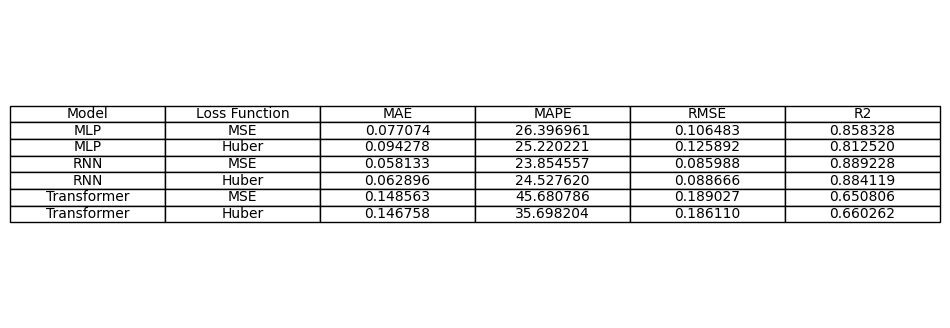

In [62]:
create_table(data)

In [75]:
import random

hyperparameter_space = {
    "dropout_rate": np.linspace(0.1, 0.5, 5),  # Range from 0.1 to 0.5
    "num_heads": [2, 4, 8, 16],  # Number of attention heads
    "key_dim": [32, 64, 128],  # Key dimension sizes
}

def fitness_function(hyperparams, input_dim, X_train, y_train, X_val, y_val, outputdim):
    model = build_transformer(input_dim, **hyperparams, outputdim=1)
    model.compile(optimizer=Adam(), loss='mean_squared_error')  # Assuming regression task
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1)
    # Evaluate on validation set
    val_loss = model.evaluate(X_val, y_val, verbose=0)
    # Return the fitness (lower is better)
    return val_loss

class SlimeMouldOptimization:
    def __init__(self, hyperparameter_space, fitness_function, num_agents=10, max_iter=100):
        self.hyperparameter_space = hyperparameter_space
        self.fitness_function = fitness_function
        self.num_agents = num_agents
        self.max_iter = max_iter
        self.agents = []
        self.best_agent = None
        self.best_fitness = float('inf')

    def initialize_agents(self):
        for _ in range(self.num_agents):
            agent = {
                "dropout_rate": random.choice(self.hyperparameter_space["dropout_rate"]),
                "num_heads": random.choice(self.hyperparameter_space["num_heads"]),
                "key_dim": random.choice(self.hyperparameter_space["key_dim"]),
            }
            self.agents.append(agent)

    def update_agents(self, input_dim, X_train, y_train, X_val, y_val):
        for agent in self.agents:
            fitness = self.fitness_function(agent, input_dim, X_train, y_train, X_val, y_val, 1)
            
            if fitness < self.best_fitness:
                self.best_fitness = fitness
                self.best_agent = agent

        for agent in self.agents:
            if random.random() < 0.5:  # Simulating the search behavior
                agent["dropout_rate"] = random.choice(self.hyperparameter_space["dropout_rate"])
            if random.random() < 0.5:
                agent["num_heads"] = random.choice(self.hyperparameter_space["num_heads"])
            if random.random() < 0.5:
                agent["key_dim"] = random.choice(self.hyperparameter_space["key_dim"])

    def run(self, input_dim, X_train, y_train, X_val, y_val):
        self.initialize_agents()
        
        for iteration in range(self.max_iter):
            print(f"Iteration {iteration+1}/{self.max_iter}")
            self.update_agents(input_dim, X_train, y_train, X_val, y_val)
            
        return self.best_agent, self.best_fitness


input_dim = (144, 7)  # Example input dimension, (sequence_length, feature_dim)

smoa = SlimeMouldOptimization(hyperparameter_space, fitness_function, num_agents=5, max_iter=20)
best_agent, best_fitness = smoa.run(input_dim, corected_X_trian, corected_y_train, corected_X_test, corected_y_test)

print(f"Best hyperparameters: {best_agent}")
print(f"Best fitness: {best_fitness}")

Iteration 1/20
Epoch 1/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0872 - val_loss: 0.0693
Epoch 2/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0724 - val_loss: 0.0694
Epoch 3/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0710 - val_loss: 0.0668
Epoch 4/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0691 - val_loss: 0.0658
Epoch 5/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0659 - val_loss: 0.0725
Epoch 6/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0660 - val_loss: 0.0655
Epoch 7/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0648 - val_loss: 0.0650
Epoch 8/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0653 - val_loss: 0.0630
Epoch 9/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0642 - val_loss: 0.0633
Epoch 10/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0637 - val_loss: 0.0601
Epoch 1/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0932 - val_loss: 0.0697
Epoch 2/10
408/408 ━━━━━━━━━━━━━━━━━━━